# Mini Project: Time series forecasting

Reference: https://datahack.analyticsvidhya.com/contest/genpact-machine-learning-hackathon-1/#ProblemStatement

Your client is a meal delivery company which operates in multiple cities. They have various fulfillment centers in these cities for dispatching meal orders to their customers. The client wants you to help these centers with demand forecasting for upcoming weeks so that these centers will plan the stock of raw materials accordingly.

The replenishment of majority of raw materials is done on weekly basis and since the raw material is perishable, the procurement planning is of utmost importance. Secondly, staffing of the centers is also one area wherein accurate demand forecasts are really helpful. Given the following information, the task is to predict the demand for the next 10 weeks (Weeks: 146-155) for the center-meal combinations in the test set:  

- Historical data of demand for a product-center combination (Weeks: 1 to 145)
- Product(Meal) features such as category, sub-category, current price and discount
- Information for fulfillment center like center area, city information etc.

Goal:
- Predict demand for the next 10 weeks (week 146-155)
- The evaluation metric for this competition is 100*RMSLE where RMSLE is Root of Mean Squared Logarithmic Error across all entries in the test set.


In [1]:
# Import packages
import pandas as pd
import os
import numpy as np 
import warnings

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split

c:\Users\myeng\anaconda3\envs\assignment6\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\myeng\AppData\Local\Temp\ipykernel_31016\1364561650.py:10: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


# EDA

#### Notes:
- Join table for 'center_id' and 'meal_id' csv
- Can see whenever got promotion, does sales increase?
- remove all the id... Use a classical model to check before and after removing
- Price difference

In [19]:
folder_to_data = "data/train_GzS76OK/train.csv"
folder_to_data_1 = "data/train_GzS76OK/fulfilment_center_info.csv"
folder_to_data_2 = "data/train_GzS76OK/meal_info.csv"

df = pd.read_csv(folder_to_data)
df1 = pd.read_csv(folder_to_data_1)
df2 = pd.read_csv(folder_to_data_2)

In [21]:
df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [22]:
print (df.shape, df1.shape, df2.shape)


(456548, 9) (77, 5) (51, 3)


In [23]:
df = pd.merge(df, df1, on='center_id')
df = pd.merge(df, df2, on='meal_id')
df.shape

(456548, 15)

In [24]:
df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,56,TYPE_C,2.0,Beverages,Thai
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,56,TYPE_C,2.0,Beverages,Thai
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,56,TYPE_C,2.0,Beverages,Thai
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,56,TYPE_C,2.0,Beverages,Thai


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
 9   city_code              456548 non-null  int64  
 10  region_code            456548 non-null  int64  
 11  center_type            456548 non-null  object 
 12  op_area                456548 non-null  float64
 13  category               456548 non-null  object 
 14  cuisine                456548 non-nu

C:\Users\myeng\AppData\Local\Temp\ipykernel_31016\1326426139.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  c1 = df.corr()


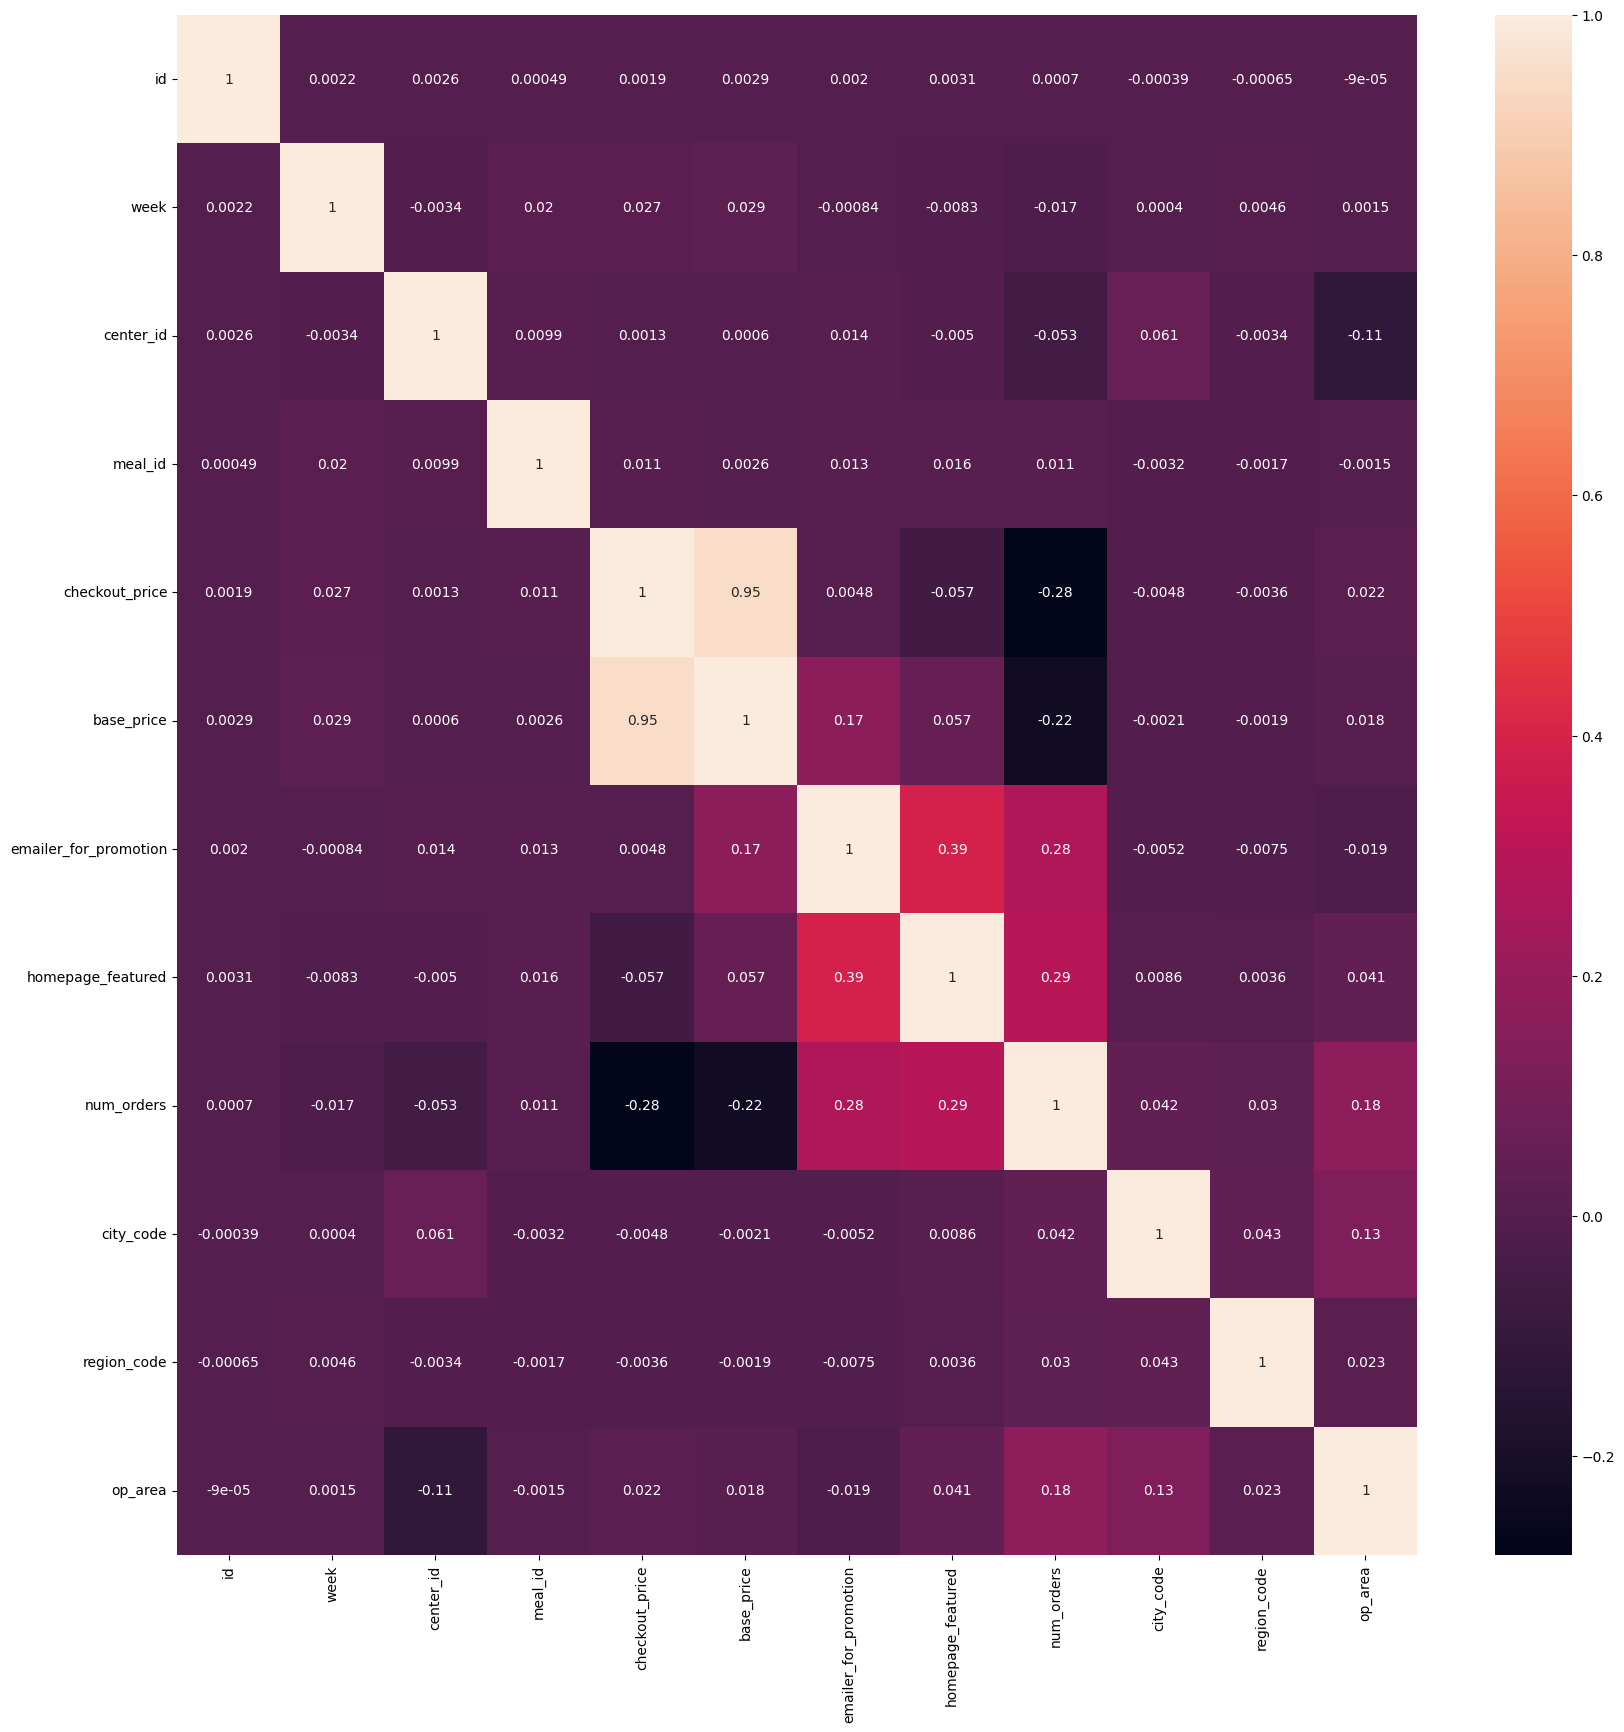

In [25]:
c1 = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(c1, annot=True)
plt.show()

c:\Users\myeng\anaconda3\envs\assignment6\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


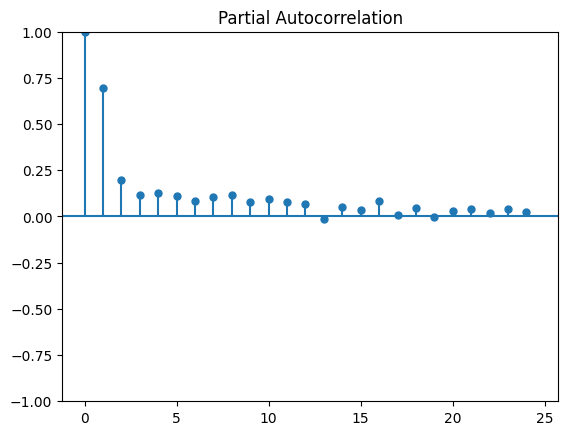

In [27]:
# Plot acf. Note that NA values have to be removed
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# df1 = df.drop(['cbwd'], axis = 1)

# Calculate the ACF (via statsmodel)
plot_pacf(df['num_orders'], alpha=0.05, lags=24)
# Show the data as a plot (via matplotlib)
plt.show()

In [32]:
#getting categorical variables
string_col=df.select_dtypes("object").columns.to_list()
print("categorical columns: " , len(string_col))

#getting numerical variables
int_col=df.select_dtypes(["int64","float64"]).columns.to_list()
print("numerical columns: " , len(int_col))

categorical columns:  3
numerical columns:  12


In [34]:
df_num = df[int_col].head()
df_num.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,2.0
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,56,2.0
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,56,2.0
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,56,2.0
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,56,2.0


In [33]:
df_str = df[string_col].head()
df_str.head()

,center_type,category,cuisine
0,TYPE_C,Beverages,Thai
1,TYPE_C,Beverages,Thai
2,TYPE_C,Beverages,Thai
3,TYPE_C,Beverages,Thai
4,TYPE_C,Beverages,Thai


In [35]:
df_num = df_num.astype(float)
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 0 to 4
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     5 non-null      float64
 1   week                   5 non-null      float64
 2   center_id              5 non-null      float64
 3   meal_id                5 non-null      float64
 4   checkout_price         5 non-null      float64
 5   base_price             5 non-null      float64
 6   emailer_for_promotion  5 non-null      float64
 7   homepage_featured      5 non-null      float64
 8   num_orders             5 non-null      float64
 9   city_code              5 non-null      float64
 10  region_code            5 non-null      float64
 11  op_area                5 non-null      float64
dtypes: float64(12)
memory usage: 520.0 bytes


In [38]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer

# Build a preprocessing step for numeric features (mainly focused on the scaling (standardized) of the data)
num_transformer = StandardScaler()

# Build a preprocessing step for nominal features (Nominal variables are variables that have two or more categories with no order)
# cat_transformer = ohe(top_categories=None, variables=nominal_cols, drop_last=False) #top_categories = top value_counts kept. 

# Build a preprocessing step for ordinal features (Ordinal variables, on the other hand, have “levels” or categories with a particular order associated with them.)
cat_transformer = OneHotEncoder()

# Merge the preprocessed data


# If using sklearn's pipelines, use sklearn.compose.ColumnTransformer to combine these pipelines, 
# taking care to apply each of them to the correct set of columns. Any feature not modified by 
# any of the pipelines can be passed through to the output dataframe (if needed).

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, int_col),
        ('cat', cat_transformer, string_col),
    ]
)



In [39]:
df = preprocessor.fit_transform(df)


In [45]:
# Load the dataset into a pandas dataframe
# df = pd.read_csv('data.csv')
one_hot_encode_columns=string_col

# Define the columns to be used in each step of the pipeline
price_columns = ['checkout_price', 'base_price']
one_hot_encode_columns = ['week', 'center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured']
passthrough_columns = ['num_orders']

# Define a pipeline that adds a new column, drops columns, and normalizes the data
preprocessing_pipeline = ColumnTransformer(transformers=[
    ('add_price_adjustment', FunctionTransformer(lambda x: x.assign(price_adjustment=x['checkout_price'] - x['base_price']), validate=False), price_columns),
    ('drop_columns', 'drop', ['id']),
    ('one_hot_encode', OneHotEncoder(sparse=False, handle_unknown='ignore', 
                                      categories='auto', 
                                      drop='first', 
                                      dtype='float64'), one_hot_encode_columns),
    ('normalize', StandardScaler(with_mean=True, with_std=True, copy=True), price_columns),
    ('passthrough', 'passthrough', passthrough_columns)
])



NameError: name 'FunctionTransformer' is not defined